<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_Ciencia_de_Dados/blob/main/IMT_TimeSeriesWithML_solucao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **Aprendizado de Máquina e Séries Temporais**

Neste Lab você vai aprender a:

1. Fazer uma engenharia de *features* para a predição de séries temporais com regressores do aprendizado de máquina

2. Como incluir na sua predição variáveis externas.

<img src="https://github.com/Rogerio-mack/Temporal/raw/main/reshape.png" width=700>

Aqui, o esquema geral de como construir as *features* para o aprendizado de uma série temporal.


Digamos agora que a série $a$, depende de mais de uma Série de Dados de Entrada no tempo, digamos a própria série $a$ e a série $b$.

$  \space \space \space \text{Lag 1: } \space \space \space \space (x_{t-1}^a,x_{t-1}^b)  \rightarrow x_t^a $

$  \space \space \space \text{Lag 2: } \space \space \space \space (x_{t-2}^a,x_{t-2}^b), (x_{t-1}^a,x_{t-1}^b)   \rightarrow x_t^a $

$  \space \space \space \text{Lag 3: } \space \space \space \space (x_{t-3}^a,x_{t-3}^b), (x_{t-2}^a,x_{t-2}^b), (x_{t-1}^a,x_{t-1}^b)   \rightarrow x_t^a $

$  \space \space \space \space \space \space ...$

$  \space \space \space \text{Lag n: } \space \space \space \space (x_{t-n}^a,x_{t-n}^b), ..., (x_{t-1}^a,x_{t-1}^b)   \rightarrow x_t^a $



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings


# **CASE**: Predição das Ondas

Neste laboratório vamos desenvolver um modelo para prever a altura das ondas com base em dados telemétricos de uma bóia marinha de monitoramento. Dados atualizados podem ser obtidos aqui [Marine Institute (Ireland)](https://erddap.marine.ie/erddap/tabledap/IWaveBNetwork.html). Aqui empregamos dados de uma única estação de medida ("SmartBay Wave Buoy").


In [ ]:
df = pd.read_csv('https://github.com/Rogerio-mack/IMT_Ciencia_de_Dados/raw/main/data/IWaveBNetwork.csv',skiprows=[1])
df.head()


,longitude,latitude,time,station_id,instrument,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,SeaTemperature,...,MeanCurSpeed,SignificantWaveHeight_qc,PeakPeriod_qc,PeakDirection_qc,UpcrossPeriod_qc,SeaTemperature_qc,Hmax_qc,THmax_qc,MeanCurDirTo_qc,MeanCurSpeed_qc
0,-9.268117,53.228966,2023-01-01T00:00:00Z,SmartBay Wave Buoy,Datawell WaveRider 4,10.53,228.74725,5.86,43.0,6.87,...,0.288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9.268117,53.228966,2023-01-01T00:05:00Z,SmartBay Wave Buoy,Datawell WaveRider 4,NaN,NaN,NaN,NaN,6.91,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9.268117,53.228966,2023-01-01T00:10:00Z,SmartBay Wave Buoy,Datawell WaveRider 4,NaN,NaN,NaN,NaN,6.91,...,0.269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-9.268117,53.228966,2023-01-01T00:15:00Z,SmartBay Wave Buoy,Datawell WaveRider 4,NaN,NaN,NaN,NaN,6.91,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-9.268117,53.228966,2023-01-01T00:20:00Z,SmartBay Wave Buoy,Datawell WaveRider 4,NaN,NaN,NaN,NaN,6.91,...,0.298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preparação dos dados

1. Selecione somente os dados

```
'time', 'SignificantWaveHeight', 'SeaTemperature', 'MeanCurSpeed'
```

2. Transforme time no índice do seu dataframe (tornando-o uma série temporal)

3. Faça o resample dos dados para diário e exclua os valores nulos restantes

4. Normalize os dados (standard scale)

In [ ]:
df.columns

Index(['longitude', 'latitude', 'time', 'station_id', 'instrument',
       'PeakPeriod', 'PeakDirection', 'UpcrossPeriod', 'SignificantWaveHeight',
       'SeaTemperature', 'Hmax', 'THmax', 'MeanCurDirTo', 'MeanCurSpeed',
       'SignificantWaveHeight_qc', 'PeakPeriod_qc', 'PeakDirection_qc',
       'UpcrossPeriod_qc', 'SeaTemperature_qc', 'Hmax_qc', 'THmax_qc',
       'MeanCurDirTo_qc', 'MeanCurSpeed_qc'],
      dtype='object')

In [ ]:
df = df[['time', 'SignificantWaveHeight',
       'SeaTemperature', 'MeanCurSpeed']]
df.head()

,time,SignificantWaveHeight,SeaTemperature,MeanCurSpeed
0,2023-01-01T00:00:00Z,43.0,6.87,0.288
1,2023-01-01T00:05:00Z,NaN,6.91,NaN
2,2023-01-01T00:10:00Z,NaN,6.91,0.269
3,2023-01-01T00:15:00Z,NaN,6.91,NaN
4,2023-01-01T00:20:00Z,NaN,6.91,0.298


In [ ]:
df.index = pd.to_datetime( df.time )
df = df.drop(columns='time')
df.head()

,SignificantWaveHeight,SeaTemperature,MeanCurSpeed
time,,,
2023-01-01 00:00:00+00:00,43.0,6.87,0.288
2023-01-01 00:05:00+00:00,NaN,6.91,NaN
2023-01-01 00:10:00+00:00,NaN,6.91,0.269
2023-01-01 00:15:00+00:00,NaN,6.91,NaN
2023-01-01 00:20:00+00:00,NaN,6.91,0.298


SignificantWaveHeight    2
SeaTemperature           2
MeanCurSpeed             2
dtype: int64


,SignificantWaveHeight,SeaTemperature,MeanCurSpeed
time,,,
2023-01-01 00:00:00+00:00,43.510638,6.662937,0.166604
2023-01-02 00:00:00+00:00,64.979167,6.789094,0.164070
2023-01-03 00:00:00+00:00,147.041667,7.842923,0.182194
2023-01-04 00:00:00+00:00,176.166667,8.584421,0.087139
2023-01-05 00:00:00+00:00,168.062500,8.700603,0.163413


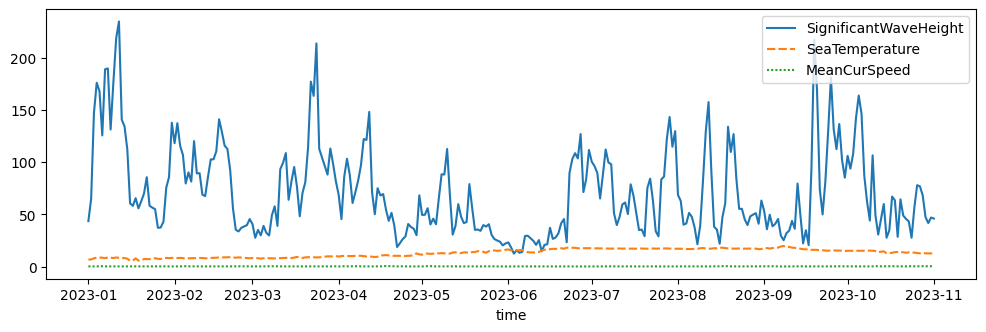

In [ ]:
plt.figure(figsize=(12,3.5))

df = df.resample('D').mean()

print(df.isnull().sum())
df = df.dropna()

display(df.head())

sns.lineplot(df)
plt.legend(loc='upper right')
plt.show()

Ao final os seus dados devem se apresentar como:

,SignificantWaveHeight,SeaTemperature,MeanCurSpeed
time,,,
2023-01-01 00:00:00+00:00,-0.648645,-1.657516,-0.166492
2023-01-02 00:00:00+00:00,-0.143661,-1.624747,-0.201545
2023-01-03 00:00:00+00:00,1.786615,-1.351014,0.049152
2023-01-04 00:00:00+00:00,2.471695,-1.158409,-1.265647
2023-01-05 00:00:00+00:00,2.281068,-1.128231,-0.210637


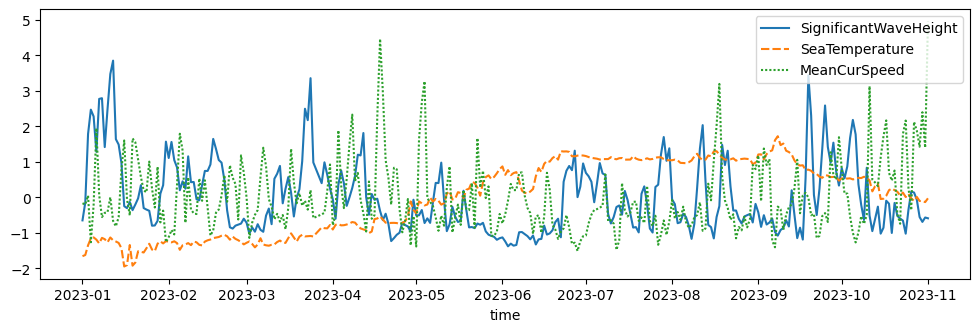

In [ ]:
plt.figure(figsize=(12,3.5))

for c in df:
  df[c] = (df[c] - df[c].mean()) / df[c].std()

display(df.head())

sns.lineplot(df)
plt.legend(loc='upper right')
plt.show()

In [ ]:
#@markdown check
df.sum().sum() == 1.2434497875801753e-13

True

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


# Objetivo

Seu objetivo agora é fazer um modelo de predição de `SignificantWaveHeight` a partir da própria série e dos demais dados.

# Determine o número de componentes com atraso a serem empregadas

Empregue os gráficos de autocorrelação PACF ou ACF para determinar a componentes com atraso relevantes em cada série temporal.

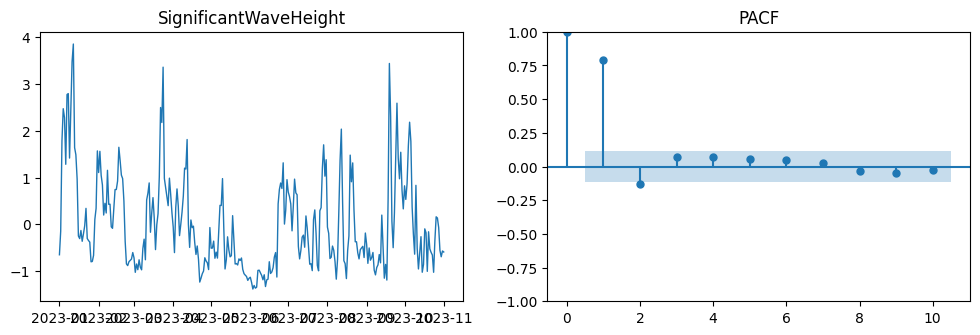

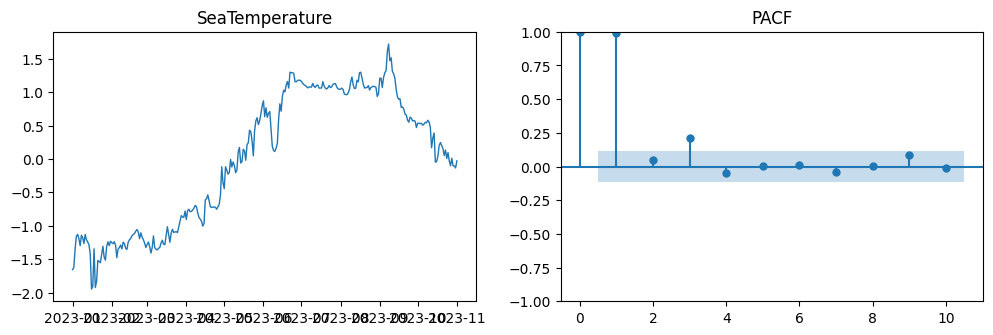

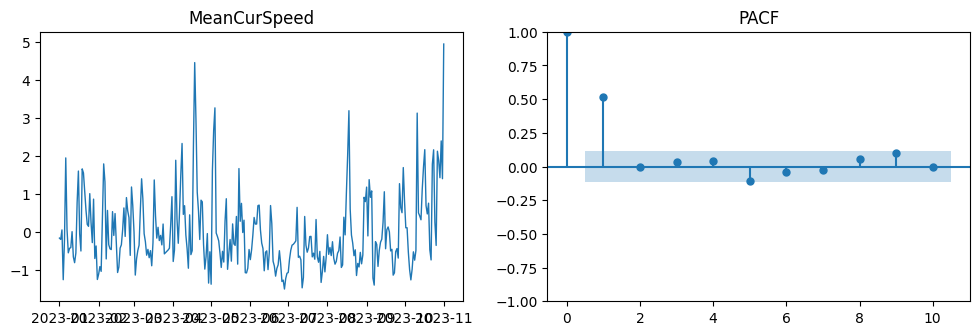

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

for c in df:
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,3.5))
  ax1.plot(df[c],linestyle='solid',alpha=1,lw=1)
  ax1.title.set_text(c)
  y=plot_pacf(df[c], lags=10,ax=ax2, title="PACF")

# Q1.

Qual o número de componentes autoregressivas significativas para cada série de dados 'SignificantWaveHeight', 'SeaTemperature', 'MeanCurSpeed'?

# Construa as *features* do modelo de previsão

Empregue o comando `shift()` para criar as novas *features* do modelo de previsão da série temporal.



# Q2.

Quantas *features* X de entrada terá o modelo?

In [ ]:
df['SignificantWaveHeight-1'] = df['SignificantWaveHeight'].shift()
df['SignificantWaveHeight-2'] = df['SignificantWaveHeight'].shift(2)

df['SeaTemperature-1'] = df['SeaTemperature'].shift()
df['SeaTemperature-2'] = df['SeaTemperature'].shift(2)
df['SeaTemperature-3'] = df['SeaTemperature'].shift(3)

df['MeanCurSpeed-1'] = df['MeanCurSpeed'].shift()

df = df.dropna()
df.head()

,SignificantWaveHeight,SeaTemperature,MeanCurSpeed,SignificantWaveHeight-1,SignificantWaveHeight-2,SeaTemperature-1,SeaTemperature-2,SeaTemperature-3,MeanCurSpeed-1
time,,,,,,,,,
2023-01-04 00:00:00+00:00,2.471695,-1.158409,-1.265647,1.786615,-0.143661,-1.351014,-1.624747,-1.657516,0.049152
2023-01-05 00:00:00+00:00,2.281068,-1.128231,-0.210637,2.471695,1.786615,-1.158409,-1.351014,-1.624747,-1.265647
2023-01-06 00:00:00+00:00,1.283832,-1.192250,1.950101,2.281068,2.471695,-1.128231,-1.158409,-1.351014,-0.210637
2023-01-07 00:00:00+00:00,2.774541,-1.297488,0.065005,1.283832,2.281068,-1.192250,-1.128231,-1.158409,1.950101
2023-01-08 00:00:00+00:00,2.794580,-1.141662,-0.555917,2.774541,1.283832,-1.297488,-1.192250,-1.128231,0.065005


In [ ]:
#@markdown check
if df.sum().sum() == 7.947447011461538:
  print(True)
else:
  print('Did you delete null values?')

True


# Separe dados de treinamento e teste

Empregue como dados de teste os 20% dos dados mais recentes da série. Não empregue dados aleatórios!

In [ ]:
def split_train_test(X, y, test_perc=0.2):

  test_size = int(len(df) * test_perc)
  train_size = len(df) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = df[['SignificantWaveHeight-1','SignificantWaveHeight-2','SeaTemperature-1', 'SeaTemperature-2','SeaTemperature-3', 'MeanCurSpeed-1']]
y = df[['SignificantWaveHeight']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

# Q3.

Qual a soma de todos os dados de X_test?

In [ ]:
X_test.sum().sum()

129.08379059777099

# Decision Tree Regressor

Aplique um Decision Tree Regressor (no modelo, informe apenas o parâmetro `random_state=0`). Você pode empregar a função `forecast_accuracy` para obter as estatísticas do modelo.

# Q4.

Qual MSE do modelo para o conjunto de teste para o Decision Tree Regressor?

In [ ]:
#@markdown forecast_accuracy
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual, print_flag=True):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                           # ME
    mae = np.mean(np.abs(forecast - actual))                  # MAE
    mpe = np.mean((forecast - actual)/actual)                 # MPE
    mse = np.mean((forecast - actual)**2)                     # MSE
    rmse = np.mean((forecast - actual)**2)**.5                # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                 # CORR
    acf1 = acf(forecast - actual)[1]                          # ACF1

    metrics = {'MSE':mse, 'MAPE':mape, 'ME':me, 'MAE': mae, 'MPE': mpe, 'RMSE':rmse, 'ACF1':acf1, 'CORR':corr}

    if print_flag:
      for key, value in metrics.items():
        print(f'{key}: \t {value:.2f}')

    return metrics

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [ ]:
cur_metrics = forecast_accuracy(y_pred, y_test.values.reshape(-1))

MSE: 	 1.04
MAPE: 	 1.60
ME: 	 -0.01
MAE: 	 0.76
MPE: 	 -0.18
RMSE: 	 1.02
ACF1: 	 0.27
CORR: 	 0.44


# XGBRegressor

Aplique um XGBRegressor (no modelo, informe apenas o parâmetro `random_state=0`). Você pode empregar a função `forecast_accuracy` para obter as estatísticas do modelo.

# Q5.

Qual MSE do modelo para o conjunto de teste para o XGBRegressor?

In [ ]:
from xgboost.sklearn import XGBRegressor

regressor =  XGBRegressor(random_state=0)

regressor.fit(X_train,y_train) # .values.reshape(-1))

y_pred = regressor.predict(X_test)

In [ ]:
cur_metrics = forecast_accuracy(y_pred, y_test.values.reshape(-1))

MSE: 	 0.87
MAPE: 	 1.35
ME: 	 -0.17
MAE: 	 0.72
MPE: 	 -0.27
RMSE: 	 0.93
ACF1: 	 0.48
CORR: 	 0.47


In [ ]:
y_pred_train = regressor.predict(X_train)

In [ ]:
#@markdown plot_forecast
def plot_forecast(y, y_pred_test, y_pred_train, title='Forecasting'):

  plt.figure(figsize=(20,6))
  plt.plot(y, color='orange', alpha=0.95, label='Real')
  plt.plot(y_test.index,y_pred, color='darkred', alpha=0.6, label='Forecast', marker='o')
  plt.plot(y_train.index,y_pred_train, color='blue', alpha=0.6, label='Predicted', marker='o')

  plt.legend()
  plt.show()

  return

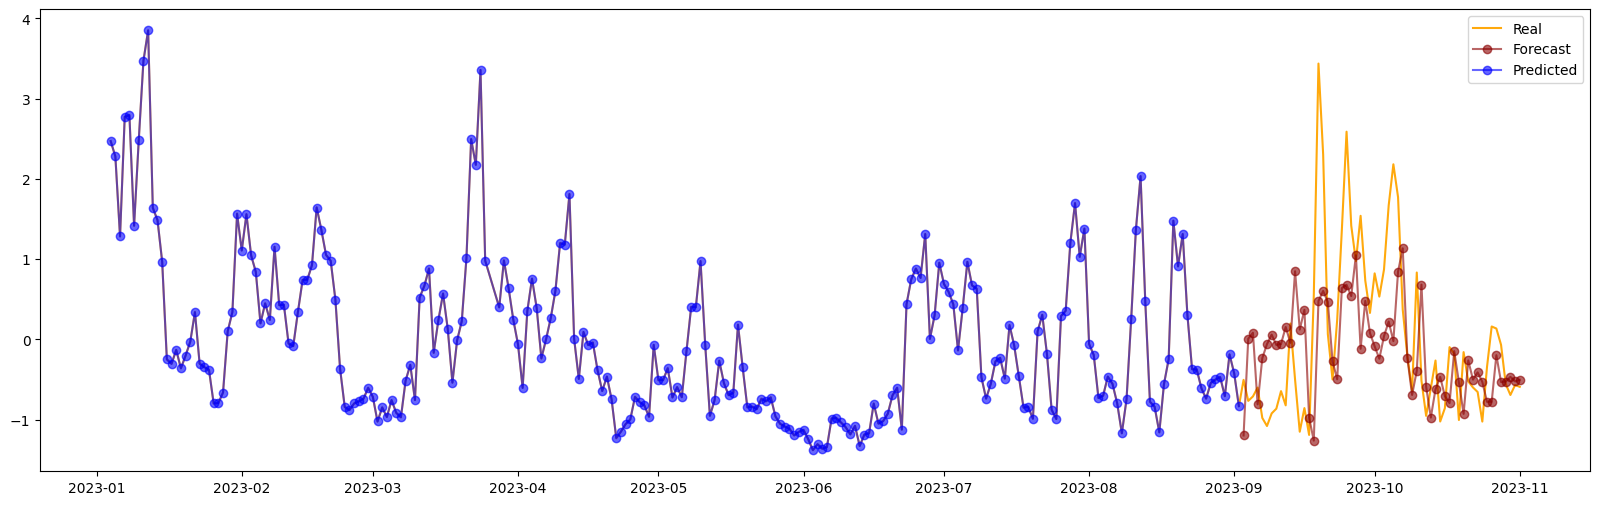

In [ ]:
plot_forecast(y, y_pred, y_pred_train, title='SignificantWaveHeight - XGBoost Regressor')



# Q6.

Compare o modelo anterior (modelo 1) com o modelo XGBRegressor, com as seguintes entradas:

```
# modelo 2
X = df[['SignificantWaveHeight-1','SignificantWaveHeight-2']]
```
e
```
# modelo 3
X = df[['SignificantWaveHeight-1','SignificantWaveHeight-2','SeaTemperature-1']]
```

Qual o melhor MSE obtido para o conjunto de teste com o XGBRegressor dos 3 modelos?

MSE: 	 0.77
MAPE: 	 1.51
ME: 	 -0.00
MAE: 	 0.68
MPE: 	 0.02
RMSE: 	 0.88
ACF1: 	 0.18
CORR: 	 0.60


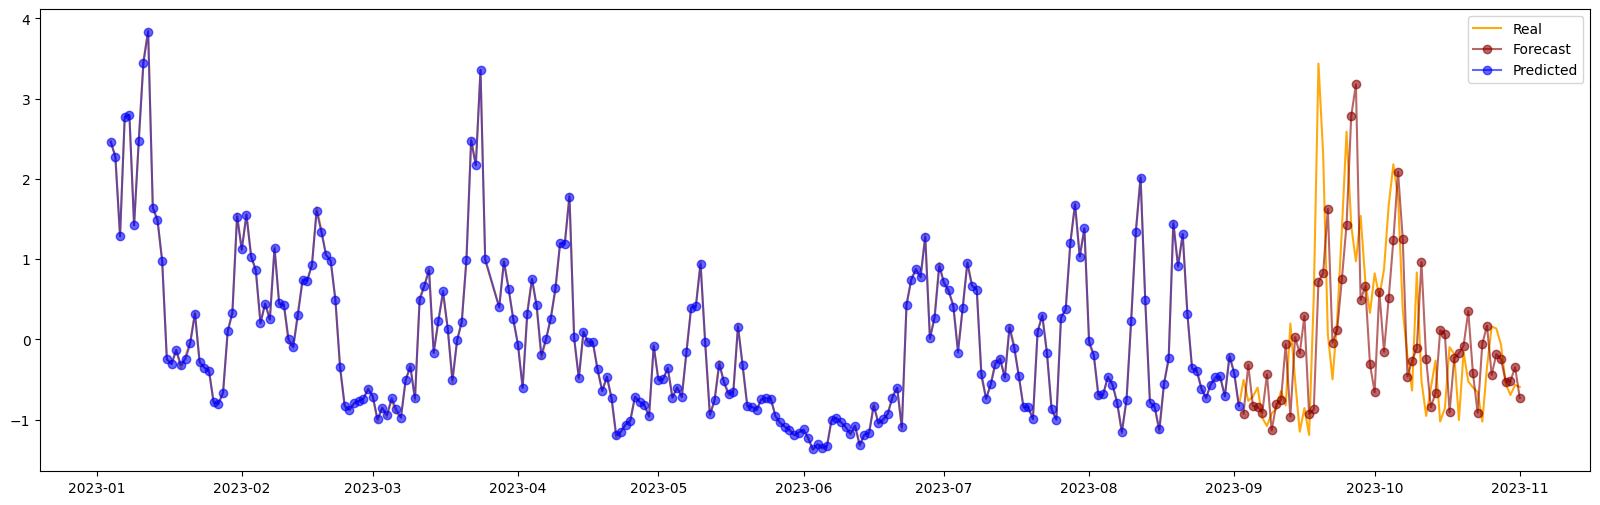

In [ ]:
X = df[['SignificantWaveHeight-1','SignificantWaveHeight-2']]
y = df[['SignificantWaveHeight']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

regressor =  XGBRegressor(random_state=0)

regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

cur_metrics = forecast_accuracy(y_pred, y_test.values.reshape(-1))

y_pred_train = regressor.predict(X_train)
plot_forecast(y, y_pred, y_pred_train, title='SignificantWaveHeight - XGBoost Regressor')

MSE: 	 0.71
MAPE: 	 1.23
ME: 	 -0.18
MAE: 	 0.63
MPE: 	 -0.29
RMSE: 	 0.84
ACF1: 	 0.33
CORR: 	 0.61


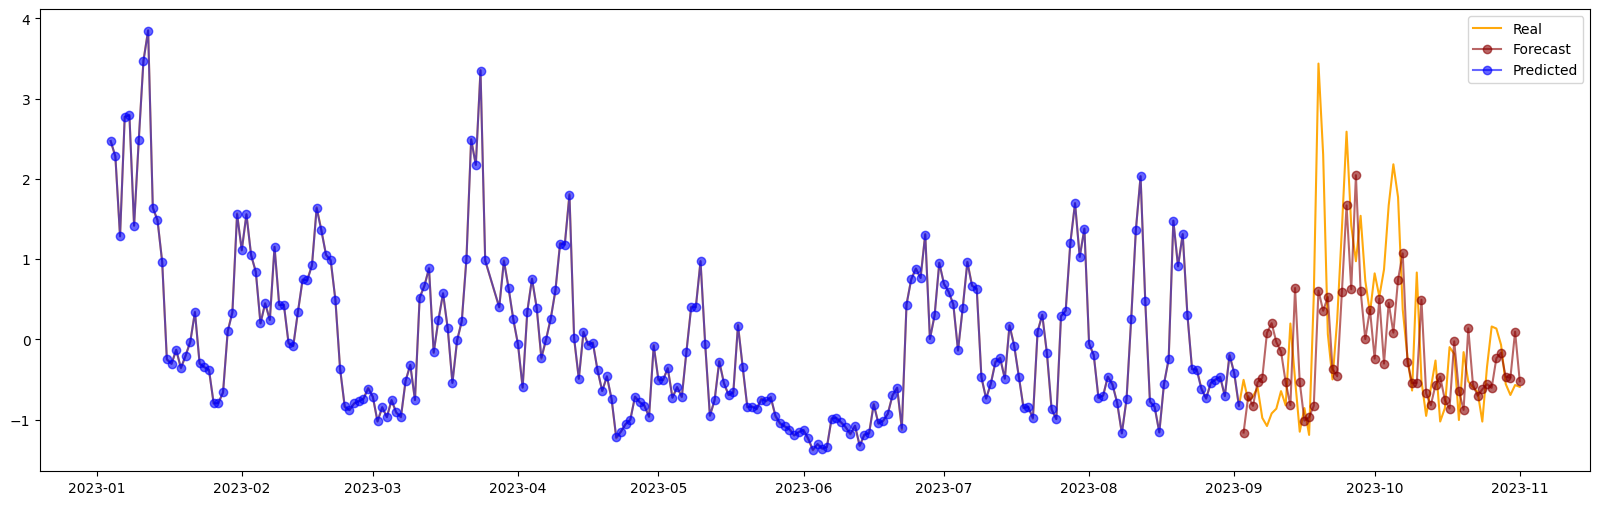

In [ ]:
X = df[['SignificantWaveHeight-1','SignificantWaveHeight-2','SeaTemperature-1']]
y = df[['SignificantWaveHeight']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

regressor =  XGBRegressor(random_state=0)

regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

cur_metrics = forecast_accuracy(y_pred, y_test.values.reshape(-1))

y_pred_train = regressor.predict(X_train)
plot_forecast(y, y_pred, y_pred_train, title='SignificantWaveHeight - XGBoost Regressor')
